In [1]:
#jupyter notebook --no-browser --port 6061 --ip=192.168.56.102


import tushare as ts
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
import scipy.optimize as sco
from cvxopt import blas, solvers
import sys


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'daily returns')

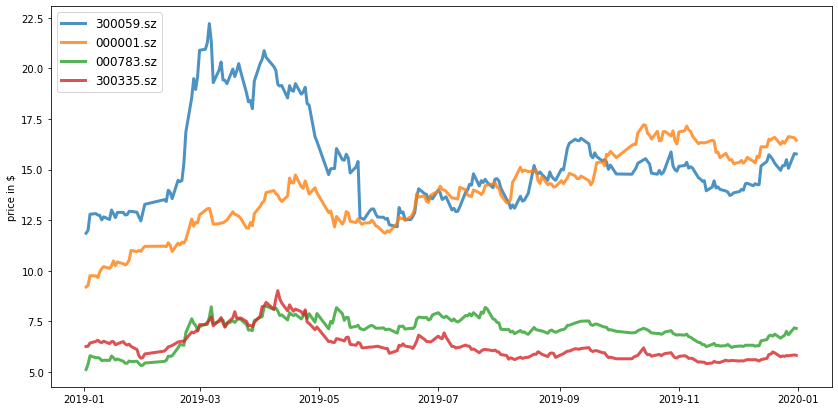

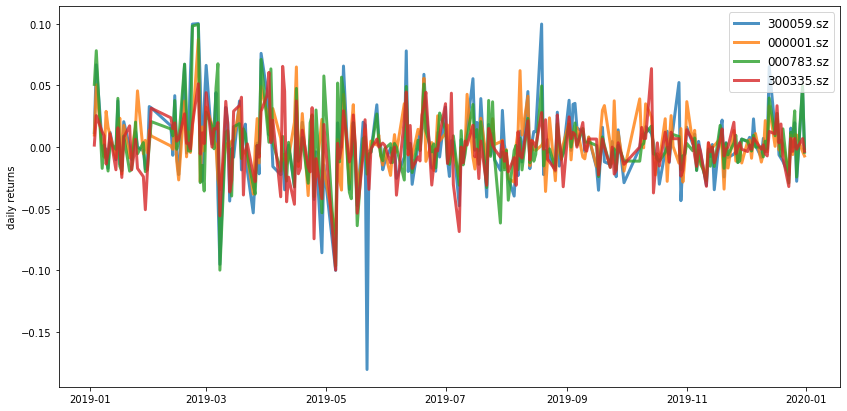

In [2]:

##################第一步#######################
#1.取基础数据现在国内可靠得数据源只有tushare一个
#以后多策略并行估计需要大批量数据读取是个大问题
###############################################
#tushare升级需要用api进行调用
ts.set_token('*************************************')
pro = ts.pro_api()


#封装取数据函数，可以兼容其他数据源
def output_data(security,source,begin_date,end_date,column): 
	  if source=='tushare':
	     fm=pro.daily(ts_code=security, start_date=begin_date, end_date=end_date)
	     fm.index=fm['trade_date']
	     fm=pd.DataFrame(fm['close'])
	     fm=fm.rename(columns={'close':security})
	  return(fm)

#initialize date	  
begin_date='20190101'
end_date='20191231'	
interest_rate = 0								# Fixed interest rate
min_return = 0.003								# Minimum desired return

##拿'300059.sz','000001.sz','000783.sz','300335.sz'四只股票做投资
##组合的例子，取这4只股票数据
convertible_bond_code=(['300059.sz','000001.sz','000783.sz','300335.sz'])
symbols= convertible_bond_code
column= "close"	
#outdata 初始化 生成
outdata=output_data(convertible_bond_code[0],'tushare',begin_date,end_date,column)	
for i in range(1,len(symbols)): 
   outdata = outdata.join(output_data(symbols[i],'tushare',begin_date,end_date,column))

####[datetime.strptime(x,'%Y%m%d') for x in outdata.index]
outdata.index=[datetime.strptime(x,'%Y%m%d') for x in outdata.index]

#reset by index order
outdata=outdata.sort_index()
#####
########画图，查看基础数据效果
############

plt.figure(figsize=(14, 7))
for c in outdata.columns.values:
    plt.plot(outdata.index, outdata[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')



################日波动率图
returns = outdata.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')
################outdata generate end####################################
##################第一步结束###########################



In [3]:
##################第二步##########################
###进行基础数据处理，个股收益，方差，协方差矩阵函数
#########
#################################
# Variable Initialization

start_date = '2019-01-04'
shift =1
returns = outdata.pct_change()
index = returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index
convertible_bond_code=(['300059.sz','000001.sz','000783.sz','300335.sz'])
StockList=convertible_bond_code
StockList.append('InterestRate')
distribution = pd.DataFrame(index=StockList)
loop_returns = pd.Series(index=index)
# Start Value
total_value = 1.0
loop_returns[index[date_index_iter]] = total_value

#########
table = outdata
original_returns = outdata.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178
##########MarkowitzOpt_new function #######
#########Markowitz 优化函数后续可以封装
###################################################
#####20200324

def portfolio_annualised_performance_new(weights, mean_returns, cov_matrix,sum_day):
    returns = np.sum(mean_returns*weights )*100 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(sum_day)
    return std, returns
    
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
    
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result


def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

############main optimisation function ##########
def display_ef_with_selected(table, mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) 
    an_rt = mean_returns
    

    return max_sharpe_allocation

##############################################
#####################Markowitz 优化函数结束###########################
######################第二步结束######################


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

Text(0.5, 1.0, 'Portfolio returns vs. Time')

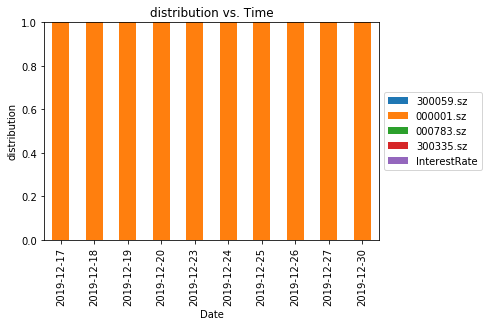

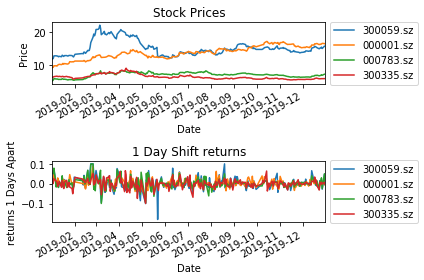

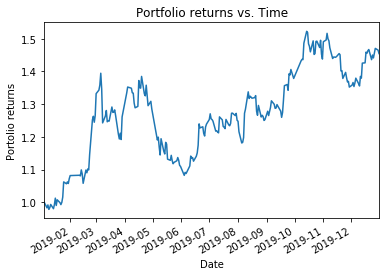

In [4]:
####################第三步，按日时间循环优化###################
#主要投资组合主要涉及个股2个变量，收益及波动率。
#我们每日循环计算时按当前日期前一步累积收益率及波动率进行预测
############################################
while date_index_iter + shift <= end_index:
  date = index[date_index_iter]
  #index_returns=original_returns[date_index_iter-1:date_index_iter+1]
  index_returns=original_returns[1:date_index_iter+1]
  index_returns.insert(4,'InterestRate',np.zeros(date_index_iter))
  #table = outdata[date_index_iter-1:date_index_iter+1]
  table = outdata[1:date_index_iter+1]
  table.insert(4,'InterestRate',np.ones(date_index_iter))	
  returns = index_returns
 ###############################
    ##################-20200324
  end_price   = np.array(table.tail(1))
  start_price = np.array(table.head(1))
  an_rt=(end_price-start_price)/start_price
  an_rt=pd.DataFrame(an_rt)
  an_rt.columns=table.columns
  an_rt=an_rt.ix[0,]
    ######################   
 ################################# 
  mean_returns = an_rt
  cov_matrix = returns.cov()
  portfolio_alloc = display_ef_with_selected(table,mean_returns, cov_matrix, risk_free_rate)
  portfolio_alloc=portfolio_alloc.values[0,]/100
  distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc
  
  # Calculating portfolio return
  date2 = index[date_index_iter+shift]
  temp1 = outdata.ix[date2]/outdata.ix[date]
  temp1.ix[StockList[-1]] = interest_rate+1
  temp2 = pd.Series(np.array(portfolio_alloc.ravel()).reshape(len(portfolio_alloc)),index=StockList)
  total_value = np.sum(loop_returns[index[date_index_iter]]*temp2*temp1)
  # Increment Date
  date_index_iter += shift
  loop_returns[index[date_index_iter]] = total_value

# Remove dates that there are no trades from returns
loop_returns = loop_returns[np.isfinite(loop_returns)]
#######################单步日循环结束#################################

###画图显示结果
# Plot portfolio allocation of last 10 periods
ax = distribution.T.ix[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('allocation.png')

# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
outdata.plot(ax=axes[0])
original_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('stocks.png', pad_inches=1)
fig.tight_layout()

# Plot portfolio returns vs. time
plt.figure()
loop_returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio returns')
plt.title('Portfolio returns vs. Time')
# plt.savefig('returns.png')


####################画图结束################################
###################第三步结束###################################


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.p

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 77.26
Annualised Volatility: 0.31


            300059.sz  000001.sz  000783.sz  300335.sz  InterestRate
allocation        0.0      100.0        0.0        0.0           0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.0


            300059.sz  000001.sz  000783.sz  300335.sz  InterestRate
allocation        0.0        0.0        0.0        0.0         100.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

300059.sz : annuaised return 23.97 , annualised volatility: 3.04
000001.sz : annuaised return 43.59 , annualised volatility: 2.0
000783.sz : annuaised return 24.79 , annualised volatility: 2.56
300335.sz : annuaised return -7.75 , annualised volatil

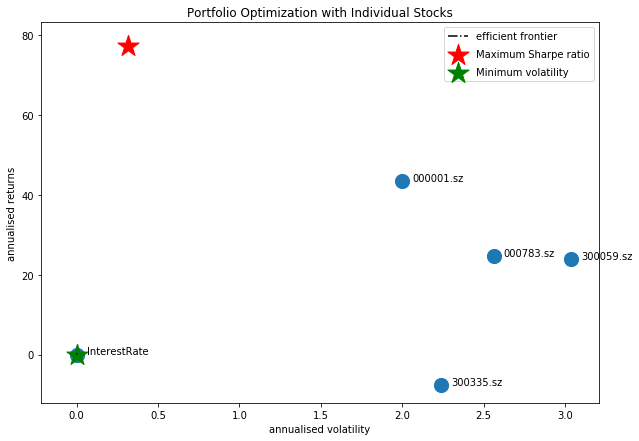

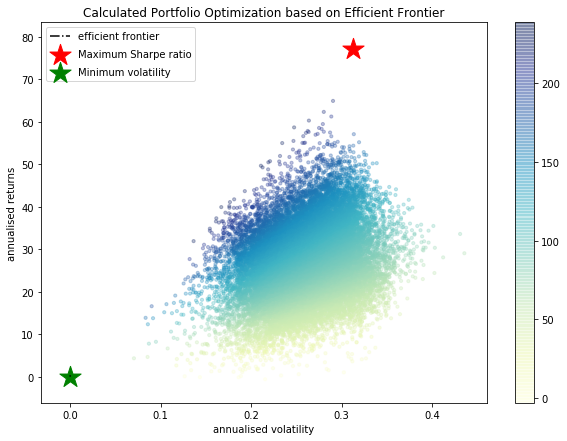

In [5]:
####################第四步，最终投资组合优化结果评估###################
############################################


################################################
def display_ef_with_selected_old(table, mean_returns, cov_matrix, risk_free_rate,sum_day):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance_new(max_sharpe['x'], mean_returns, cov_matrix,sum_day)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance_new(min_vol['x'], mean_returns, cov_matrix,sum_day)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns)*100 
    #an_rt = mean_returns
    ##################-20200324
    end_price   = np.array(table.tail(1))
    start_price = np.array(table.head(1))
    an_rt=(end_price-start_price)/end_price
    an_rt=pd.DataFrame(an_rt)
    an_rt.columns=table.columns
    an_rt=an_rt.ix[0,]*100
    ######################
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt.ix[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

##################
def random_portfolios_new(num_portfolios, mean_returns, cov_matrix, risk_free_rate,sum_day):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance_new(weights, mean_returns, cov_matrix,sum_day)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record
    
def display_calculated_ef_with_random_old(table,mean_returns, cov_matrix, num_portfolios, risk_free_rate,sum_day):
    results, _ = random_portfolios_new(num_portfolios,mean_returns, cov_matrix, risk_free_rate,sum_day)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance_new(max_sharpe['x'], mean_returns, cov_matrix,sum_day)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance_new(min_vol['x'], mean_returns, cov_matrix,sum_day)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

#############
date_index_iter=243
date = index[date_index_iter]
#index_returns=original_returns[date_index_iter-1:date_index_iter+1]
index_returns=original_returns[1:date_index_iter+1]
index_returns.insert(4,'InterestRate',np.zeros(date_index_iter))
#table = outdata[date_index_iter-1:date_index_iter+1]
table = outdata[1:date_index_iter+1]
table.insert(4,'InterestRate',np.ones(date_index_iter))	
returns = index_returns
 #  ##############################
      ##################-20200324
end_price   = np.array(table.tail(1))
start_price = np.array(table.head(1))
an_rt=(end_price-start_price)/table.head(1)
an_rt=pd.DataFrame(an_rt)
an_rt.columns=table.columns
an_rt=an_rt.ix[0,]
      ######################   
 #  ################################ 
mean_returns = an_rt
cov_matrix = index_returns.cov()
display_ef_with_selected_old(table,mean_returns, cov_matrix, risk_free_rate,date_index_iter)
display_calculated_ef_with_random_old(table,mean_returns, cov_matrix, num_portfolios, risk_free_rate,date_index_iter)
##################